## COMMONVOICE DATA

In [3]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  # zodat Python src als modulepad herkent
from analysis import extract_pos_tag_scores
from analysis import load_file, compare_bleu_buckets, calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter

## BLUE BUCKET ANALYSE PER SENTENCE

In [4]:
# Load data 
data_dir = "/Users/sedatgunay/Desktop/compare-mt-2/commonvoice/"
ref_path = os.path.join(data_dir, "common_test_ref_texts.txt")
knn_path = os.path.join(data_dir, "common_test_knn_texts.txt")
van_path = os.path.join(data_dir, "common_test_van_texts.txt")

# 📄 3. Laad bestanden
refs = load_file(ref_path)
knn = load_file(knn_path)
van = load_file(van_path)

# ✅ Controle: gelijke lengte
assert len(refs) == len(knn) == len(van), "Lengtes van de bestanden komen niet overeen."

# 📊 4. BLEU-bucket edges instellen
bucket_edges = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]

df_bleu = compare_bleu_buckets(refs, knn, van, bucket_edges)

df_bleu.style.background_gradient(cmap="RdYlGn", subset=["Verschil (sys1 - sys2)"])

,BLEU-bucket,Aantal sys1 - kNN-MT,Aantal sys2 - Vanilla,Verschil (sys1 - sys2)
0,"[0.0,10.0)",38,39,-1
1,"[10.0,20.0)",91,74,17
2,"[20.0,30.0)",107,127,-20
3,"[30.0,40.0)",227,204,23
4,"[40.0,50.0)",289,321,-32
5,"[50.0,60.0)",512,546,-34
6,"[60.0,70.0)",549,574,-25
7,"[70.0,80.0)",1007,1044,-37
8,"[80.0,90.0)",639,637,2
9,>=90.0,81,72,9


## POS - BUCKET ANALYSE 

In [3]:
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/commonvoice/comparemt_output_commonvoice_pos/index.html"

print("POS LABEL TAGGING SCORES – COMMONVOICE")
df_commonvoice_pos = extract_pos_tag_scores(html_path)
display(df_commonvoice_pos)

POS LABEL TAGGING SCORES – COMMONVOICE


,Label,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,ADJ,0.9403,0.9374,0.0029
1,NOUN,0.9223,0.9218,0.0005
2,PROPN,0.8276,0.8300,-0.0024
3,VERB,0.9361,0.9375,-0.0014
4,ADV,0.9671,0.9635,0.0036
5,NUM,0.8166,0.6730,0.1436
6,DET,0.9770,0.9774,-0.0004
7,PRON,0.9610,0.9575,0.0035
8,ADP,0.9819,0.9791,0.0028
9,CCONJ,0.9735,0.9709,0.0026


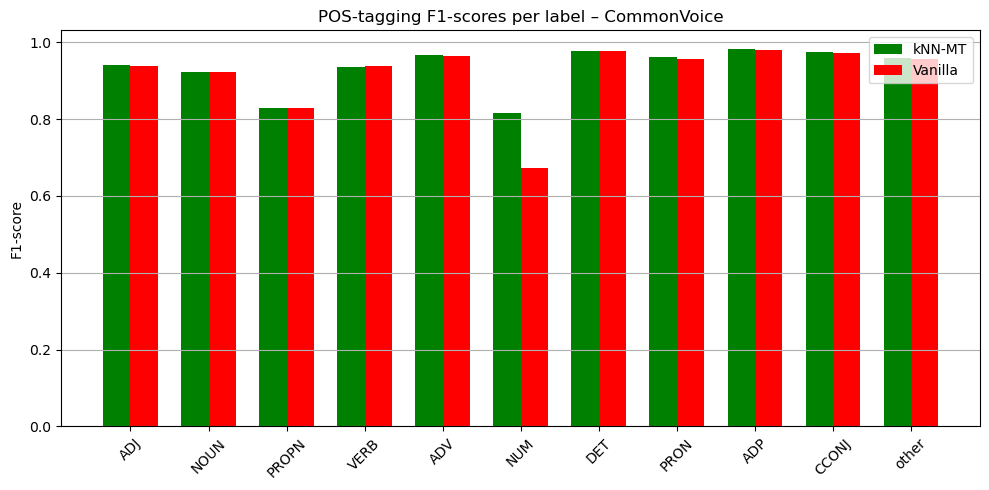

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

labels = df_commonvoice_pos["Label"]
x = range(len(labels))
width = 0.35

ax.bar(x, df_commonvoice_pos["kNN-MT (sys1)"], width, label="kNN-MT", color="green")
ax.bar([i + width for i in x], df_commonvoice_pos["Vanilla (sys2)"], width, label="Vanilla", color="red")

ax.set_ylabel("F1-score")
ax.set_title("POS-tagging F1-scores per label – CommonVoice")
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis="y")
plt.tight_layout()
plt.show()

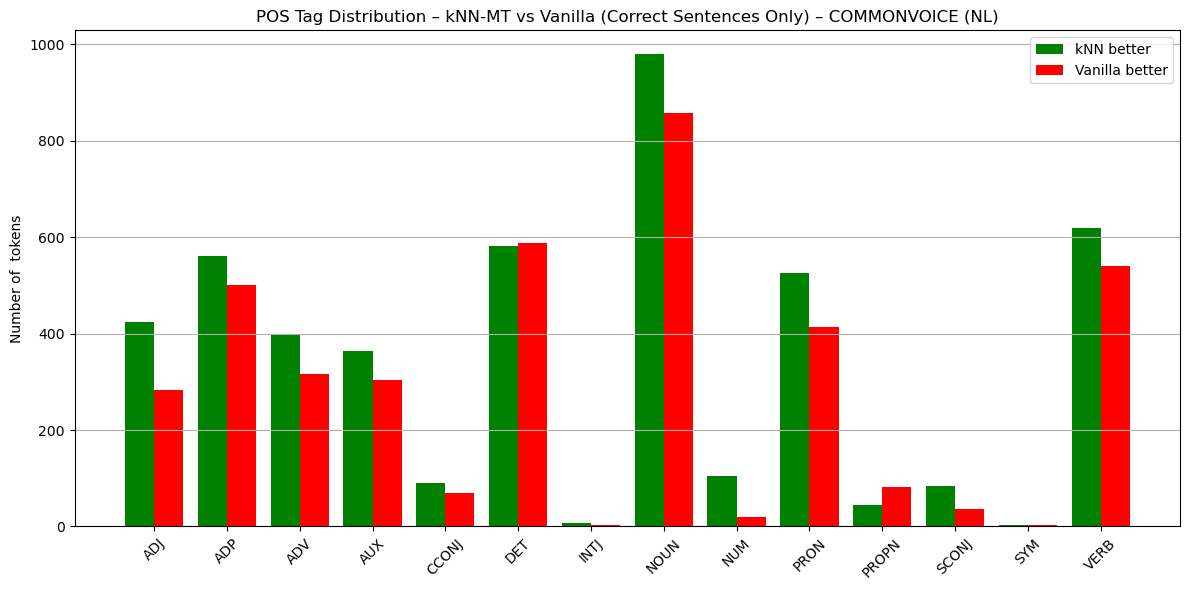

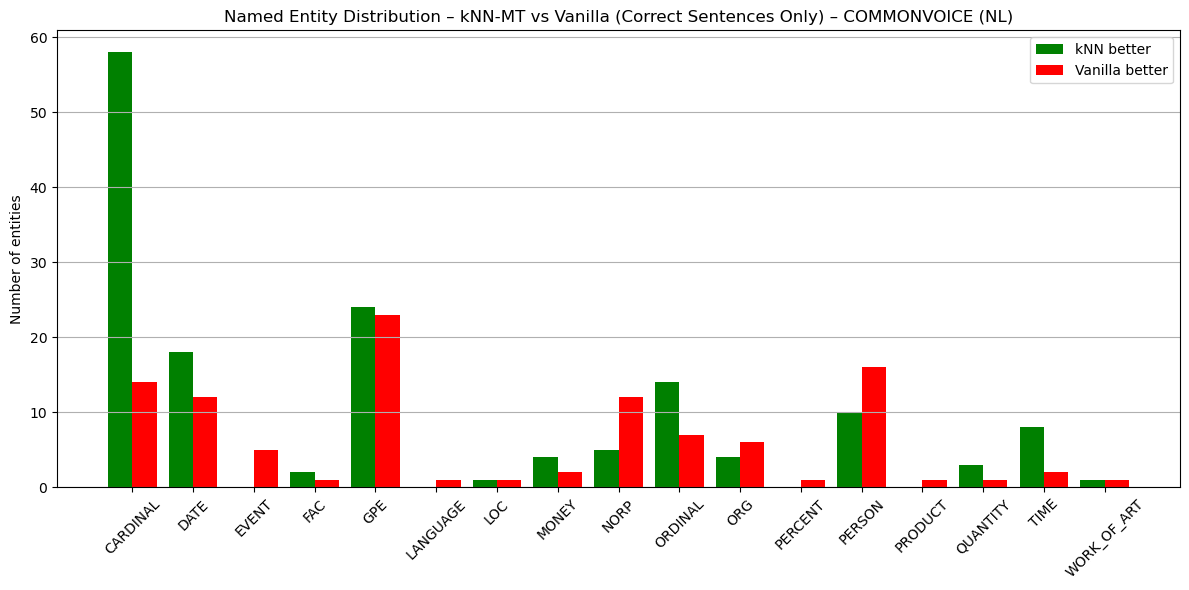

In [5]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/commonvoice"
lang = "nl"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_texts.pkl"))

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE ({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE ({lang.upper()})",
    ylabel="Number of entities"
)

### WER ANALYSE

In [6]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])


# Vind zinnen waar kNN significant beter was
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.5)
gain_indices = [entry[0] for entry in gain_outliers]

# gain_outliers

Mean WER (kNN): 0.055888029951793906
Mean WER (van): 0.058506872035616254


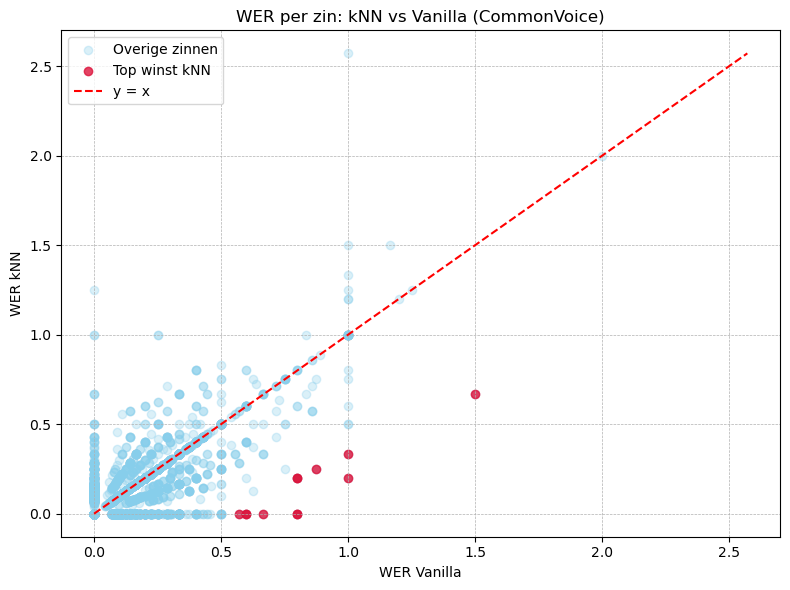

In [9]:
plot_knn_gain_scatter(wer_knn, wer_van,
    gain_indices,
    domain_label="CommonVoice"
)

In [10]:
import pandas as pd

df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])

# Sorteer op grootste winst, optioneel
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)

# Bekijk de eerste rijen
display(df_gain)  


,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,1408,Ze wou weer de heldin uithangen.,Het is heel raar waar je nu heen bent.,Zij waren weer de helderdom.,1.500000,0.666667,0.833333
1,615,Als dessert krijgen we tiramisu.,Als de zee krijg ik een tiramisu.,Als dossier krijgen we tiramisu.,1.000000,0.200000,0.800000
2,3227,Drie maal negen is zevenentwintig.,3 x 9 is 27.,Drie maal negen is zevenentwintig.,0.800000,0.000000,0.800000
3,8531,U hebt hierover niets gezegd.,We hebben je over niets gezegd.,U hebt hierover niets gezegd.,0.800000,0.000000,0.800000
4,3426,Frietjes maak je in een friteuse.,"Fritsjes, maagje en fritoso.","Frities, maak je in een frité.",1.000000,0.333333,0.666667
5,10498,Er bespottelijk uitzien.,Er bespotten lijkt uitzien.,Er bespottelijk uitzien.,0.666667,0.000000,0.666667
6,3862,Ik had een buis voor het vak geschiedenis.,"Ik kan hem buigen, omdat het vaak geschieden is.",Ik kan een baas voor het vak geschiedenis.,0.875000,0.250000,0.625000
7,1137,Acht min vijf is drie.,8-5 is 3.,8 min vijf is drie.,0.800000,0.200000,0.600000
8,7758,Er zijn veel diepgewortelde verschillen.,Er zijn veel diep geworden door de verschillen.,Er zijn veel diepgeworden verschillen.,0.800000,0.200000,0.600000
9,3817,Zes keer twee is twaalf.,6 keer 2 is 12.,Zes keer twee is twaalf.,0.600000,0.000000,0.600000
